In [9]:
import os
import laspy as lp
import numpy as np
import pylas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from scipy.spatial import ConvexHull
from sklearn.linear_model import RANSACRegressor

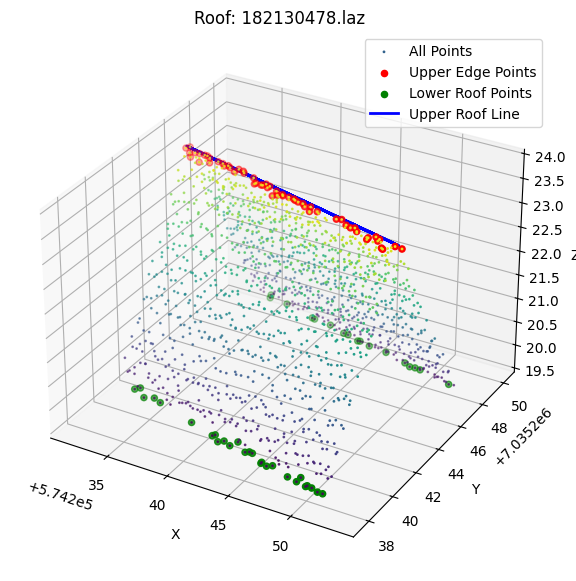

,file_name,point_count,x,y,z,min_z,max_z,upper_line
0,182130478.laz,1431,"[574233.04, 574233.29, 574233.55, 574232.86, 5...","[7035248.890000001, 7035249.4, 7035249.91, 703...","[21.0, 20.57, 20.080000000000002, 22.61, 22.12...",19.71,23.79,"LINESTRING (574239.25 7035244.455674204, 57424..."


In [31]:
import os
import numpy as np
import geopandas as gpd
import laspy as lp
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from shapely.geometry import Polygon, LineString

folder = "sample_roofdata_50"

tolerance = 0.15  # Toleranse for å finne nesten høyeste og laveste punkter

roof_polygons = []

# Gå gjennom filene i mappen
for roof in os.listdir(folder):
    if roof.endswith(".laz"):
        file_path = os.path.join(folder, roof)
        
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            point_count = fh.header.point_count
            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z

            max_z = np.max(z)
            min_z = np.min(z)

            # Filtrer punktene nær maks høyde (øverste kant)
            upper_edge_mask = (z >= max_z - tolerance)
            upper_x = np.array(x[upper_edge_mask])
            upper_y = np.array(y[upper_edge_mask])
            upper_z = np.array(z[upper_edge_mask])

            # Filtrer punktene nær minimum høyde (nederste takflate)
            lower_edge_mask = (z <= min_z + tolerance)
            lower_x = np.array(x[lower_edge_mask])
            lower_y = np.array(y[lower_edge_mask])
            lower_z = np.array(z[lower_edge_mask])

            # Tilpass linje for øvre kant
            def fit_line(x_vals, y_vals):
                if len(x_vals) > 2:  # Må ha minst to punkter for å lage en linje
                    X = np.array(x_vals).reshape(-1, 1)  # Konverter til NumPy-array
                    y_values = np.array(y_vals).reshape(-1, 1)

                    model = RANSACRegressor()
                    model.fit(X, y_values)
                    line_y_pred = model.predict(X)  # Estimerte y-verdier for linjen
                    return line_y_pred.flatten()
                else:
                    return y_vals  # Returner originale verdier hvis det er for få punkter

            upper_line_y = fit_line(upper_x, upper_y)

            # Opprett en linje for øvre kant
            upper_line = LineString(zip(upper_x, upper_line_y))

            # Lagre polygonen
            roof_polygons.append({
                "file_name": roof,
                "point_count": point_count,
                "x": x,
                "y": y,
                "z": z,
                "min_z": min_z,
                "max_z": max_z,
                "upper_line": upper_line,
            })

            # Plot resultatene
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x, y, z, s=1, c=z, cmap='viridis', label='All Points')  # Alle punkter
            ax.scatter(upper_x, upper_y, upper_z, s=20, c='red', label='Upper Edge Points')  # Øvre kantpunkter
            ax.scatter(lower_x, lower_y, lower_z, s=20, c='green', label='Lower Roof Points')  # Nedre punkter

            # Tegn øvre linje
            ax.plot(upper_x, upper_line_y, max_z, color='blue', linewidth=2, label='Upper Roof Line')
        
            ax.set_title(f"Roof: {roof}")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_zlabel("Z")
            ax.legend()
            plt.show()

            break  # Fjern denne for å prosessere alle takene

# Opprett en GeoDataFrame med polygoner
df = gpd.GeoDataFrame(roof_polygons)
df

In [3]:
##kjapt generert for mer info


import os
import laspy as lp
import matplotlib.pyplot as plt

folder = "sample_roofdata_50"

# Opprett en tom dictionary for å lagre informasjonen
roofs_dict = {}

# Gå gjennom filene i mappen
for roof in os.listdir(folder):
    if roof.endswith(".laz"):
        # Lag hele filstien
        file_path = os.path.join(folder, roof)
        
        # Åpne .laz-filen og hent informasjon
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            header = fh.header
            point_count = header.point_count
            
            # Hent header-informasjon
            roofs_dict[roof] = {
                "file_path": file_path,
                "point_count": point_count,
                "version": f"{header.version.major}.{header.version.minor}",
                "point_format": header.point_format.id,
                "scale": header.scales,
                "offset": header.offsets,
                "min_bounds": header.mins,
                "max_bounds": header.maxs,
                "z-høyde": header.maxs[2],

            }
            
            # Les punktskydata
            laz_data = fh.read()
            x = laz_data.x
            y = laz_data.y
            z = laz_data.z

   
        ## Plot punktsky i 3D
        #fig = plt.figure(figsize=(10, 7))
        #ax = fig.add_subplot(111, projection='3d')
        #scatter = ax.scatter(x, y, z, s=1, c=z, cmap='viridis')  # Fargepunkter basert på Z
        #ax.set_title(f"Punktsky: {roof}")
        #ax.set_xlabel("X")
        #ax.set_ylabel("Y")
        #ax.set_zlabel("Z")
        #plt.colorbar(scatter, label="Høyde (Z)")
        #plt.show()
        #
        #break  # Fjern denne hvis du vil visualisere alle filer

# Skriv ut innhentet informasjon
import pprint
pprint.pprint(roofs_dict)

{'10444144.laz': {'file_path': 'sample_roofdata_50/10444144.laz',
                  'max_bounds': array([5.70982180e+05, 7.03068727e+06, 9.99200000e+01]),
                  'min_bounds': array([5.70972050e+05, 7.03067314e+06, 9.77400000e+01]),
                  'offset': array([0., 0., 0.]),
                  'point_count': 1403,
                  'point_format': 3,
                  'scale': array([0.01, 0.01, 0.01]),
                  'version': '1.2',
                  'z-høyde': np.float64(99.92)},
 '10468485.laz': {'file_path': 'sample_roofdata_50/10468485.laz',
                  'max_bounds': array([5.70291810e+05, 7.02779759e+06, 9.13700000e+01]),
                  'min_bounds': array([5.70273190e+05, 7.02777559e+06, 8.71700000e+01]),
                  'offset': array([0., 0., 0.]),
                  'point_count': 1991,
                  'point_format': 3,
                  'scale': array([0.01, 0.01, 0.01]),
                  'version': '1.2',
                  'z-høyde': np.f

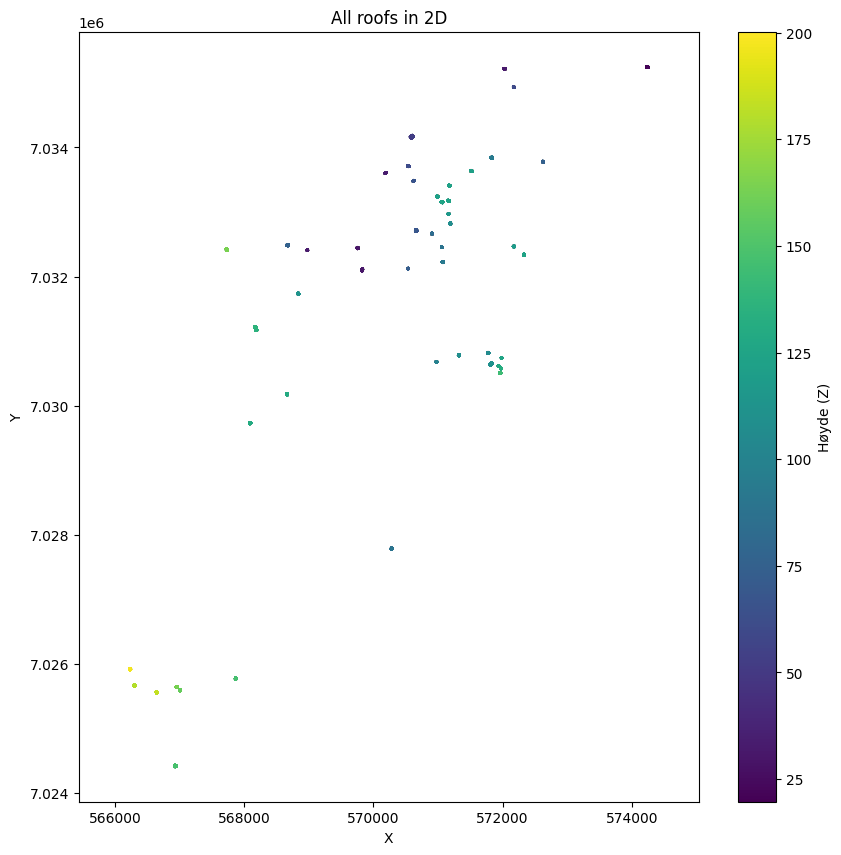

In [4]:
import os
import laspy as lp
import matplotlib.pyplot as plt

folder = "sample_roofdata_50"

# Opprett lister for å samle alle punktene
all_x = []
all_y = []
all_z = []

# Gå gjennom filene i mappen
for roof in os.listdir(folder):
    if roof.endswith(".laz"):
        # Lag hele filstien ved å kombinere mappen og filnavnet
        file_path = os.path.join(folder, roof)
        
        # Åpne .laz-filen og les punktene
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z
            
            # Legg punktene til samlelistene
            all_x.extend(x)
            all_y.extend(y)
            all_z.extend(z)

# Plot alle takene i 2D (ovenfra)
plt.figure(figsize=(10, 10))
scatter = plt.scatter(all_x, all_y, c=all_z, s=1, cmap='viridis')  # Farger basert på høyde (z)
plt.title("All roofs in 2D")
plt.xlabel("X")
plt.ylabel("Y")

# Legg til en fargeskala for høyden
cbar = plt.colorbar(scatter)
cbar.set_label("Høyde (Z)")

plt.axis('equal')  # Sikrer at aksene har samme skala
plt.show()

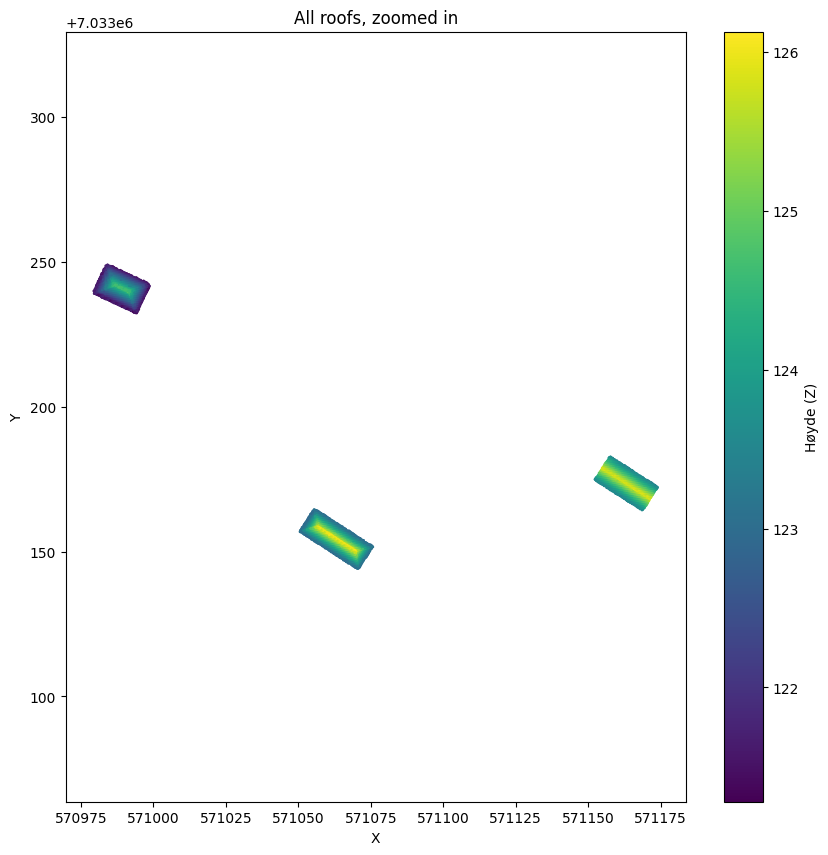

In [5]:
import os
import laspy as lp
import matplotlib.pyplot as plt

folder = "sample_roofdata_50"

# Opprett lister for å samle alle punktene
all_x = []
all_y = []
all_z = []

# Gå gjennom filene i mappen
for roof in os.listdir(folder):
    if roof.endswith(".laz"):
        # Lag hele filstien ved å kombinere mappen og filnavnet
        file_path = os.path.join(folder, roof)
        
        # Åpne .laz-filen og les punktene
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z
            
            # Legg punktene til samlelistene
            all_x.extend(x)
            all_y.extend(y)
            all_z.extend(z)

# Definer området du vil zoome inn på
x_min, x_max = 570000, 572000  # Juster disse verdiene for ditt område
y_min, y_max = 7.0330e6, 7.03335e6

# Filtrer punkter som faller innenfor området
zoom_x = [x for x, y in zip(all_x, all_y) if x_min <= x <= x_max and y_min <= y <= y_max]
zoom_y = [y for x, y in zip(all_x, all_y) if x_min <= x <= x_max and y_min <= y <= y_max]
zoom_z = [z for x, y, z in zip(all_x, all_y, all_z) if x_min <= x <= x_max and y_min <= y <= y_max]

# Plot punktene i zoom-området
plt.figure(figsize=(10, 10))
scatter = plt.scatter(zoom_x, zoom_y, c=zoom_z, s=1, cmap='viridis')  # Farger basert på høyde (z)
plt.title(f"All roofs, zoomed in")
plt.xlabel("X")
plt.ylabel("Y")

# Legg til en fargeskala for høyden
cbar = plt.colorbar(scatter)
cbar.set_label("Høyde (Z)")

plt.axis('equal')  # Sikrer at aksene har samme skala
plt.show()